# Colab preinstall

In [ ]:
!uv pip install ipympl
# restart to apply changes
import os
os.kill(os.getpid(), 9)

Using Python 3.11.13 environment at: /usr
Resolved 75 packages in 428ms
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
⠙ Preparing packages... (0/2)
ipympl     ------------------------------     0 B/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 16.00 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 16.00 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 32.00 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 48.00 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 61.80 KiB/503.62 KiB
⠙ Preparing packages... (0/2)
ipympl     ------------------------------ 

In [30]:
from google.colab import output
output.enable_custom_widget_manager()

# Imports

In [1]:
from numpy import dtype
import torch
import torch.functional as F
import matplotlib.pyplot as plt
import tqdm
from typing import Callable
from pathlib import Path

%matplotlib ipympl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

# Model definition. Same as in paper

### FT features

In [2]:

class FourierFeatureEmbedding(torch.nn.Module):
    def __init__(self, input_dim, mapping_size, scale=10.0):
        super(FourierFeatureEmbedding, self).__init__()
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        # B is typically sampled from a Gaussian distribution.
        # mapping_size determines the number of new features (half for sin, half for cos)
        self.B = torch.nn.Parameter(torch.randn((input_dim, mapping_size // 2)) * self.scale, requires_grad=False)

    def forward(self, x):
        # x has shape (batch_size, input_dim), where input_dim is 2 for (x,t)
        # x_proj will have shape (batch_size, mapping_size // 2)
        x_proj = 2 * torch.pi * x @ self.B

        # Concatenate sin and cos features
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [21]:
# non_linear_f = torch.nn.Tanh
# non_linear_f = torch.nn.GELU
non_linear_f = torch.nn.SELU
# non_linear_f = torch.nn.Sigmoid
layers_sizes = (2, 64, 128, 256, 256, 128, 64, 1)


class MyModel(torch.nn.Module):
    def __init__(self, dtype, fte_mapping_size=None):
        super(MyModel, self).__init__()
        layers = []
        ins = layers_sizes[0]
        self.fte = None
        if fte_mapping_size is not None:
            self.fte = FourierFeatureEmbedding(input_dim=1, mapping_size=fte_mapping_size)
            ins += fte_mapping_size
        for clayer in layers_sizes[1:-1]:
            layers.append(torch.nn.Linear(ins, clayer, dtype=dtype))
            layers.append(non_linear_f())
            ins = clayer
        layers.append(torch.nn.Linear(ins, layers_sizes[-1], dtype=dtype))
        self.layers = torch.nn.Sequential(*layers)

    def forward(self, x):
        if self.fte:
            x = torch.cat((x, self.fte(x[:, 0].unsqueeze(1))), dim=-1)
            # x = torch.cat((x, torch.sin(x[:, 1]).unsqueeze(1), torch.cos(x[:, 1]).unsqueeze(1)), dim=-1)
        return self.layers(x)   


In [4]:
# Using L1 loss because working with complex numbers, MSE does not support them
loss_f = torch.nn.L1Loss()

In [22]:
model = MyModel(dtype=dtype, fte_mapping_size=64).to(device)

## Loading weights if they are exist

In [7]:
weights_path = "weights_rad2.pt"
if Path(weights_path).is_file():
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.eval()

# Problem

$$i \frac{\partial \psi}{\partial t} = -k \frac{\partial^2 \psi}{\partial x^2} - \gamma |\psi|^2 \psi$$

$$\psi(0, x) = 2 sech x $$

In [8]:
psi = 0
k = 0.5
gamma = 1
N = 2
f = lambda psi: gamma * torch.abs(psi) ** 2
exact = lambda x, t: ((4 * torch.cosh(3 * x) + 3 * torch.exp(4 * 0+1j * t) * torch.cosh(x))*torch.exp(0+1j * t / 2)) / (torch.cosh(4 * x) + 4 * torch.cosh(2 * x) + 3 * torch.cos(4 * t))

### Visualize exact

/home/alex1um/Desktop/Projects/IKKN/.venv/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/alex1um/Desktop/Projects/IKKN/.venv/lib/python3.12/site-packages/torch/_tensor.py:1227: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


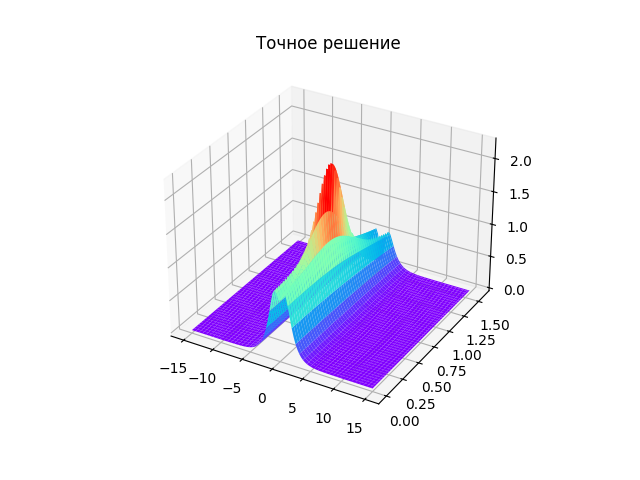

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_title("Точное решение")
x, t = torch.linspace(-15, 15, 100), torch.linspace(0, torch.pi / 2, 100)
grid_x, grid_t = torch.meshgrid(x, t)
ax.plot_surface(grid_x, grid_t, exact(grid_x, grid_t), cmap="rainbow")

# Loss functions

In [10]:
def loss_IC(y_IC, x):
    # t = 0
    return loss_f(y_IC, N * 1 / torch.cosh(x))

In [11]:
def residual(y, x, t):
    dudt = torch.autograd.grad(y, t, torch.ones_like(y, device=device, dtype=dtype), create_graph=True)[0]
    dudx = torch.autograd.grad(y, x, torch.ones_like(y, device=device, dtype=dtype), create_graph=True)[0]
    du2dx2 = torch.autograd.grad(dudx, x, torch.ones_like(y, device=device, dtype=dtype), create_graph=True)[0]
    return 0+1j * dudt + k*du2dx2 + f(y) * y

In [12]:
def loss_PDE(y, x, t):
    return loss_f(residual(y, x, t), torch.zeros_like(y, device=device, dtype=dtype))

In [13]:
def res_for_generate(x, y):
    x = x.clone()
    x.requires_grad = True
    y = y.clone()
    y.requires_grad = True
    xy = torch.vstack((x, y)).T
    z = model(xy).squeeze()
    return residual(z, x, y).abs()

In [14]:
def res_data_for_generate(x, y):
    x = x.clone()
    x.requires_grad = True
    y = y.clone()
    y.requires_grad = True
    xy = torch.vstack((x, y)).T
    z = model(xy).squeeze()
    return (z - exact(x, y)).abs()

# TRAINING

# params

In [15]:
x_bounds = (-15, 15)
t_bounds = (0, torch.pi / 2)
EPOCHS_NUM = 5000
PDE_POINTS_NUM = 8000
DATA_POINTS_NUM = 20000
IC_POINTS_NUM = 2000
train_data = True

In [23]:
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=1000)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999)

## RAD

The algorithm of implementation is:
1. Throw some random points to area
2. Calculate function value for these points
3. Use torch.multinomial with replacement to sample points with respect to absolute function value
4. Create new points for each of sampled by adding some noise
5. Add some random points to explore more zones
6. Go to 2  

In [17]:
from typing import Callable


class RADPointGenerator:
    def __init__(
        self,
        func: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
        x_bounds,
        y_bounds,
        max_points=1000,
        min_explore_points=100,
        noise_factor=0.1,
        device="cpu",
        dtype=torch.float32,
    ):
        self.func = func
        self.x_bounds = x_bounds
        self.y_bounds = y_bounds
        self.device = device
        self.dtype = dtype
        self.max_points = max_points
        self.min_explore_points_n = min_explore_points
        self.n_points_to_generate = max_points - min_explore_points
        self.x_noise = (x_bounds[1] - x_bounds[0]) * noise_factor
        self.y_noise = (y_bounds[1] - y_bounds[0]) * noise_factor
        self.points_x, self.points_y = self.sample_uniform(self.max_points)

    def sample_uniform(self, n):
        x_min, x_max = self.x_bounds
        y_min, y_max = self.y_bounds
        xs = torch.empty(n, device=self.device, dtype=self.dtype).uniform_(x_min, x_max)
        ys = torch.empty(n, device=self.device, dtype=self.dtype).uniform_(y_min, y_max)
        if self.dtype == torch.complex64 or self.dtype == torch.complex128:
            xs.imag[:] = 0
            ys.imag[:] = 0
        return xs, ys

    def generate(self):
        x, y = self.points_x, self.points_y
        weights = self.func(x, y).abs()
        chosen_indexes = torch.multinomial(
            weights, self.n_points_to_generate, replacement=True
        )
        x_new = x[chosen_indexes] + torch.empty(
            self.n_points_to_generate, device=self.device
        ).uniform_(-self.x_noise, self.x_noise)
        y_new = y[chosen_indexes] + torch.empty(
            self.n_points_to_generate, device=self.device
        ).uniform_(-self.y_noise, self.y_noise)
        if self.dtype == torch.complex64 or self.dtype == torch.complex128:
            x_new.real = torch.clamp(
                x_new.real,
                *self.x_bounds,
            )
            y_new.real = torch.clamp(
                y_new.real,
                *self.y_bounds,
            )
            x_new.imag[:] = 0
            y_new.imag[:] = 0
        else:
            x_new = torch.clamp(
                x_new,
                *self.x_bounds,
            )
            y_new: torch.Tensor = torch.clamp(
                y_new,
                *self.y_bounds,
            )

        x_explore, y_explore = self.sample_uniform(self.min_explore_points_n)

        x_new = torch.cat((x_new, x_explore))
        y_new = torch.cat((y_new, y_explore))

        self.points_x = x_new
        self.points_y = y_new
        return x_new, y_new


In [18]:
sampler_pde = RADPointGenerator(
    res_for_generate,
    x_bounds,
    t_bounds,
    max_points=PDE_POINTS_NUM,
    min_explore_points=PDE_POINTS_NUM // 10,
    device=device,
    noise_factor=0.00001,
    dtype=dtype,
)
sampler_data = RADPointGenerator(
    res_data_for_generate,
    x_bounds,
    t_bounds,
    max_points=DATA_POINTS_NUM,
    min_explore_points=DATA_POINTS_NUM // 10,
    device=device,
    noise_factor=0.00001,
    dtype=dtype,
)

In [24]:
for i in tqdm.tqdm(range(EPOCHS_NUM)):
    x_pde, t_pde = sampler_pde.generate()
    x_pde = x_pde.clone()
    x_pde.requires_grad = True
    t_pde = t_pde.clone()
    t_pde.requires_grad = True
    xt_pde = torch.vstack((x_pde, t_pde)).T
    if train_data:
        x_data, t_data = sampler_data.generate()
        x_data = x_data.clone()
        x_data.requires_grad = True
        t_data = t_data.clone()
        t_data.requires_grad = True
        xt_data = torch.vstack((x_data, t_data)).T
    x_ic = torch.rand(IC_POINTS_NUM, device=device) * (x_bounds[1] - x_bounds[0]) + x_bounds[0]
    if dtype == torch.complex64 or dtype == torch.complex128:
        x_ic.imag[:] = 0
    x_ic.requires_grad = True
    t_ic = torch.zeros_like(x_ic)
    t_ic.requires_grad = True
    xt_ic = torch.vstack((x_ic, t_ic)).T
    optim.zero_grad()
    y_pde = model(xt_pde).squeeze()
    if train_data:
        y_data = model(xt_data).squeeze()
    y_ic = model(xt_ic).squeeze()
    closs = loss_PDE(y_pde, x_pde, t_pde) + loss_IC(y_ic, x_ic)
    if train_data:
        closs += loss_f(y_data, exact(x_data, t_data))
    closs.backward()
    optim.step()
    lr_scheduler.step()
    if i % 100 == 0:
        print(closs, optim.param_groups[0]['lr'])

  0%|          | 1/5000 [00:00<21:36,  3.85it/s]

tensor(323.6657, device='cuda:0', grad_fn=<AddBackward0>) 0.000999


  2%|▏         | 101/5000 [00:26<27:49,  2.93it/s]

tensor(53.8270, device='cuda:0', grad_fn=<AddBackward0>) 0.0009038873549665952


  4%|▍         | 201/5000 [00:54<28:58,  2.76it/s]

tensor(11.7053, device='cuda:0', grad_fn=<AddBackward0>) 0.000817830180649157


  6%|▌         | 301/5000 [01:24<28:36,  2.74it/s]

tensor(8.1126, device='cuda:0', grad_fn=<AddBackward0>) 0.0007399663251239438


  8%|▊         | 401/5000 [01:54<29:14,  2.62it/s]

tensor(4.1959, device='cuda:0', grad_fn=<AddBackward0>) 0.0006695157201007332


 10%|█         | 501/5000 [02:25<28:40,  2.62it/s]

tensor(3.8692, device='cuda:0', grad_fn=<AddBackward0>) 0.0006057725659163234


 12%|█▏        | 601/5000 [02:57<29:00,  2.53it/s]

tensor(4.6064, device='cuda:0', grad_fn=<AddBackward0>) 0.0005480982605780109


 14%|█▍        | 701/5000 [03:28<28:22,  2.53it/s]

tensor(3.4497, device='cuda:0', grad_fn=<AddBackward0>) 0.0004959150020176674


 16%|█▌        | 801/5000 [04:00<27:43,  2.52it/s]

tensor(3.8274, device='cuda:0', grad_fn=<AddBackward0>) 0.0004486999994614646


 18%|█▊        | 901/5000 [04:32<27:05,  2.52it/s]

tensor(3.8755, device='cuda:0', grad_fn=<AddBackward0>) 0.0004059802359226587


 20%|██        | 1001/5000 [05:03<26:28,  2.52it/s]

tensor(4.3956, device='cuda:0', grad_fn=<AddBackward0>) 0.00036732772934619225


 22%|██▏       | 1101/5000 [05:36<30:04,  2.16it/s]

tensor(3.3306, device='cuda:0', grad_fn=<AddBackward0>) 0.0003323552449295445


 24%|██▍       | 1201/5000 [06:09<26:44,  2.37it/s]

tensor(3.5731, device='cuda:0', grad_fn=<AddBackward0>) 0.00030071241566430546


 26%|██▌       | 1301/5000 [06:42<28:26,  2.17it/s]

tensor(3.3757, device='cuda:0', grad_fn=<AddBackward0>) 0.00027208223223265714


 28%|██▊       | 1402/5000 [07:18<18:55,  3.17it/s]

tensor(3.5572, device='cuda:0', grad_fn=<AddBackward0>) 0.0002461778670932768


 30%|███       | 1501/5000 [07:50<23:36,  2.47it/s]

tensor(3.7550, device='cuda:0', grad_fn=<AddBackward0>) 0.00022273980093919914


 32%|███▏      | 1602/5000 [08:26<20:39,  2.74it/s]

tensor(3.2612, device='cuda:0', grad_fn=<AddBackward0>) 0.00020153322273945825


 34%|███▍      | 1701/5000 [09:00<23:18,  2.36it/s]

tensor(3.6761, device='cuda:0', grad_fn=<AddBackward0>) 0.00018234567731717976


 36%|███▌      | 1801/5000 [09:31<22:16,  2.39it/s]

tensor(3.3529, device='cuda:0', grad_fn=<AddBackward0>) 0.00016498493689671458


 38%|███▊      | 1901/5000 [10:04<22:53,  2.26it/s]

tensor(3.4856, device='cuda:0', grad_fn=<AddBackward0>) 0.000149277075296198


 40%|████      | 2001/5000 [10:36<18:45,  2.66it/s]

tensor(3.7245, device='cuda:0', grad_fn=<AddBackward0>) 0.00013506472547210178


 42%|████▏     | 2101/5000 [11:06<18:34,  2.60it/s]

tensor(3.4091, device='cuda:0', grad_fn=<AddBackward0>) 0.0001222055029592267


 44%|████▍     | 2201/5000 [11:39<18:46,  2.49it/s]

tensor(3.4952, device='cuda:0', grad_fn=<AddBackward0>) 0.00011057057941158942


 46%|████▌     | 2302/5000 [12:10<13:38,  3.30it/s]

tensor(3.1959, device='cuda:0', grad_fn=<AddBackward0>) 0.00010004339195341888


 48%|████▊     | 2401/5000 [12:40<15:54,  2.72it/s]

tensor(3.1964, device='cuda:0', grad_fn=<AddBackward0>) 9.051847541007218e-05


 50%|█████     | 2501/5000 [13:10<16:17,  2.56it/s]

tensor(3.3990, device='cuda:0', grad_fn=<AddBackward0>) 8.190040571973865e-05


 52%|█████▏    | 2601/5000 [13:41<14:37,  2.73it/s]

tensor(3.3759, device='cuda:0', grad_fn=<AddBackward0>) 7.410284394064617e-05


 54%|█████▍    | 2701/5000 [14:10<13:42,  2.79it/s]

tensor(3.5694, device='cuda:0', grad_fn=<AddBackward0>) 6.704767127628931e-05


 56%|█████▌    | 2801/5000 [14:39<13:10,  2.78it/s]

tensor(3.4642, device='cuda:0', grad_fn=<AddBackward0>) 6.066420645304801e-05


 58%|█████▊    | 2901/5000 [15:08<12:33,  2.79it/s]

tensor(3.2191, device='cuda:0', grad_fn=<AddBackward0>) 5.488849760960262e-05


 60%|██████    | 3001/5000 [15:36<11:45,  2.83it/s]

tensor(3.4085, device='cuda:0', grad_fn=<AddBackward0>) 4.966268160403805e-05


 62%|██████▏   | 3102/5000 [16:06<09:39,  3.28it/s]

tensor(3.3070, device='cuda:0', grad_fn=<AddBackward0>) 4.4934404319942077e-05


 64%|██████▍   | 3201/5000 [16:38<11:56,  2.51it/s]

tensor(3.2958, device='cuda:0', grad_fn=<AddBackward0>) 4.0656296163915934e-05


 66%|██████▌   | 3301/5000 [17:11<11:37,  2.44it/s]

tensor(3.2742, device='cuda:0', grad_fn=<AddBackward0>) 3.6785497499840384e-05


 68%|██████▊   | 3401/5000 [17:42<09:35,  2.78it/s]

tensor(3.2375, device='cuda:0', grad_fn=<AddBackward0>) 3.328322926552656e-05


 70%|███████   | 3501/5000 [18:12<09:26,  2.64it/s]

tensor(3.1955, device='cuda:0', grad_fn=<AddBackward0>) 3.0114404470033573e-05


 72%|███████▏  | 3601/5000 [18:43<08:48,  2.65it/s]

tensor(3.2084, device='cuda:0', grad_fn=<AddBackward0>) 2.7247276679492355e-05


 74%|███████▍  | 3701/5000 [19:13<08:50,  2.45it/s]

tensor(3.1425, device='cuda:0', grad_fn=<AddBackward0>) 2.4653121969839172e-05


 76%|███████▌  | 3801/5000 [19:45<07:53,  2.53it/s]

tensor(3.1672, device='cuda:0', grad_fn=<AddBackward0>) 2.2305951160146912e-05


 78%|███████▊  | 3901/5000 [20:15<06:55,  2.64it/s]

tensor(3.4181, device='cuda:0', grad_fn=<AddBackward0>) 2.0182249443602846e-05


 80%|████████  | 4001/5000 [20:46<06:33,  2.54it/s]

tensor(3.4005, device='cuda:0', grad_fn=<AddBackward0>) 1.8260740807661886e-05


 82%|████████▏ | 4101/5000 [21:19<05:59,  2.50it/s]

tensor(3.2084, device='cuda:0', grad_fn=<AddBackward0>) 1.6522174883251335e-05


 84%|████████▍ | 4201/5000 [21:50<05:04,  2.62it/s]

tensor(3.1876, device='cuda:0', grad_fn=<AddBackward0>) 1.4949134087605164e-05


 86%|████████▌ | 4301/5000 [22:21<05:11,  2.24it/s]

tensor(3.2317, device='cuda:0', grad_fn=<AddBackward0>) 1.3525859128615012e-05


 88%|████████▊ | 4401/5000 [22:54<04:13,  2.37it/s]

tensor(3.1966, device='cuda:0', grad_fn=<AddBackward0>) 1.223809112253714e-05


 90%|█████████ | 4501/5000 [23:28<03:41,  2.25it/s]

tensor(3.1929, device='cuda:0', grad_fn=<AddBackward0>) 1.1072928743333602e-05


 92%|█████████▏| 4601/5000 [24:01<02:40,  2.49it/s]

tensor(3.1979, device='cuda:0', grad_fn=<AddBackward0>) 1.001869897251791e-05


 94%|█████████▍| 4702/5000 [24:35<02:06,  2.36it/s]

tensor(3.2932, device='cuda:0', grad_fn=<AddBackward0>) 9.06484015463039e-06


 96%|█████████▌| 4802/5000 [25:14<01:12,  2.72it/s]

tensor(3.2697, device='cuda:0', grad_fn=<AddBackward0>) 8.201796186750588e-06


 98%|█████████▊| 4902/5000 [25:52<00:36,  2.68it/s]

tensor(3.2631, device='cuda:0', grad_fn=<AddBackward0>) 7.420920781999088e-06


100%|██████████| 5000/5000 [26:29<00:00,  3.14it/s]


## random

In [22]:
for i in tqdm.tqdm(range(EPOCHS_NUM)):
    x_pde = torch.rand(PDE_POINTS_NUM, device=device) * (x_bounds[1] - x_bounds[0]) + x_bounds[0]
    t_pde = torch.rand(PDE_POINTS_NUM, device=device) * (t_bounds[1] - t_bounds[0]) + t_bounds[0]
    x_pde.requires_grad = True
    t_pde.requires_grad = True
    xt_pde = torch.stack((x_pde, t_pde), dim=1)
    x_ic = torch.rand(IC_POINTS_NUM, device=device) * (x_bounds[1] - x_bounds[0]) + x_bounds[0]
    x_ic.requires_grad = True
    t_ic = torch.zeros_like(x_ic, device=device)
    t_ic.requires_grad = True
    xt_ic = torch.stack((x_ic, t_ic), dim=1)
    optim.zero_grad()
    y_pde = model(xt_pde).squeeze()
    y_ic = model(xt_ic).squeeze()
    closs = loss_PDE(y_pde, x_pde, t_pde) + loss_IC(y_ic, x_ic)
    if train_data:
        x_data = torch.rand(PDE_POINTS_NUM, device=device) * (x_bounds[1] - x_bounds[0]) + x_bounds[0]
        t_data = torch.rand(PDE_POINTS_NUM, device=device) * (t_bounds[1] - t_bounds[0]) + t_bounds[0]
        x_data.requires_grad = True
        t_data.requires_grad = True
        xt_data = torch.stack((x_pde, t_pde), dim=1)
        closs += loss_f(model(xt_data).squeeze(), exact(x_data, t_data))
    closs.backward()
    optim.step()
    lr_scheduler.step()
    if i % 100 == 0:
        print(closs, optim.param_groups[0]['lr'])

  0%|          | 0/5000 [00:00<?, ?it/s]

/home/alex1um/Desktop/Projects/IKKN/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 3/5000 [00:00<22:24,  3.72it/s]  

tensor(0.8601, device='cuda:0', grad_fn=<AddBackward0>) 0.000999


  2%|▏         | 103/5000 [00:15<11:20,  7.20it/s]

tensor(0.4022, device='cuda:0', grad_fn=<AddBackward0>) 0.0009038873549665952


  4%|▍         | 203/5000 [00:30<11:11,  7.14it/s]

tensor(0.3754, device='cuda:0', grad_fn=<AddBackward0>) 0.000817830180649157


  6%|▌         | 303/5000 [00:46<10:57,  7.14it/s]

tensor(0.4109, device='cuda:0', grad_fn=<AddBackward0>) 0.0007399663251239438


  8%|▊         | 403/5000 [01:01<10:55,  7.01it/s]

tensor(0.3786, device='cuda:0', grad_fn=<AddBackward0>) 0.0006695157201007332


 10%|█         | 503/5000 [01:16<10:43,  6.99it/s]

tensor(0.3675, device='cuda:0', grad_fn=<AddBackward0>) 0.0006057725659163234


 12%|█▏        | 603/5000 [01:32<10:34,  6.93it/s]

tensor(0.3860, device='cuda:0', grad_fn=<AddBackward0>) 0.0005480982605780109


 14%|█▍        | 703/5000 [01:48<10:24,  6.88it/s]

tensor(0.3804, device='cuda:0', grad_fn=<AddBackward0>) 0.0004959150020176674


 16%|█▌        | 803/5000 [02:04<10:14,  6.83it/s]

tensor(0.3794, device='cuda:0', grad_fn=<AddBackward0>) 0.0004486999994614646


 18%|█▊        | 903/5000 [02:19<09:58,  6.84it/s]

tensor(0.3795, device='cuda:0', grad_fn=<AddBackward0>) 0.0004059802359226587


 20%|██        | 1003/5000 [02:35<09:51,  6.76it/s]

tensor(0.3904, device='cuda:0', grad_fn=<AddBackward0>) 0.00036732772934619225


 22%|██▏       | 1103/5000 [02:52<09:35,  6.77it/s]

tensor(0.3674, device='cuda:0', grad_fn=<AddBackward0>) 0.0003323552449295445


 24%|██▍       | 1203/5000 [03:08<09:22,  6.75it/s]

tensor(0.3727, device='cuda:0', grad_fn=<AddBackward0>) 0.00030071241566430546


 26%|██▌       | 1303/5000 [03:24<09:15,  6.65it/s]

tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>) 0.00027208223223265714


 28%|██▊       | 1403/5000 [03:40<08:57,  6.69it/s]

tensor(0.3831, device='cuda:0', grad_fn=<AddBackward0>) 0.0002461778670932768


 30%|███       | 1503/5000 [03:56<08:42,  6.69it/s]

tensor(0.3580, device='cuda:0', grad_fn=<AddBackward0>) 0.00022273980093919914


 32%|███▏      | 1603/5000 [04:12<08:28,  6.68it/s]

tensor(0.3810, device='cuda:0', grad_fn=<AddBackward0>) 0.00020153322273945825


 34%|███▍      | 1703/5000 [04:29<08:31,  6.45it/s]

tensor(0.3520, device='cuda:0', grad_fn=<AddBackward0>) 0.00018234567731717976


 36%|███▌      | 1803/5000 [04:45<08:09,  6.54it/s]

tensor(0.3934, device='cuda:0', grad_fn=<AddBackward0>) 0.00016498493689671458


 38%|███▊      | 1903/5000 [05:02<07:50,  6.58it/s]

tensor(0.3929, device='cuda:0', grad_fn=<AddBackward0>) 0.000149277075296198


 40%|████      | 2003/5000 [05:18<07:33,  6.61it/s]

tensor(0.3505, device='cuda:0', grad_fn=<AddBackward0>) 0.00013506472547210178


 42%|████▏     | 2103/5000 [05:35<07:24,  6.52it/s]

tensor(0.3823, device='cuda:0', grad_fn=<AddBackward0>) 0.0001222055029592267


 44%|████▍     | 2203/5000 [05:52<07:04,  6.60it/s]

tensor(0.3887, device='cuda:0', grad_fn=<AddBackward0>) 0.00011057057941158942


 46%|████▌     | 2303/5000 [06:08<06:53,  6.53it/s]

tensor(0.4055, device='cuda:0', grad_fn=<AddBackward0>) 0.00010004339195341888


 48%|████▊     | 2403/5000 [06:25<06:36,  6.55it/s]

tensor(0.3796, device='cuda:0', grad_fn=<AddBackward0>) 9.051847541007218e-05


 50%|█████     | 2503/5000 [06:41<06:29,  6.41it/s]

tensor(0.3871, device='cuda:0', grad_fn=<AddBackward0>) 8.190040571973865e-05


 52%|█████▏    | 2603/5000 [06:58<06:07,  6.52it/s]

tensor(0.3653, device='cuda:0', grad_fn=<AddBackward0>) 7.410284394064617e-05


 54%|█████▍    | 2703/5000 [07:15<05:53,  6.50it/s]

tensor(0.3599, device='cuda:0', grad_fn=<AddBackward0>) 6.704767127628931e-05


 56%|█████▌    | 2803/5000 [07:32<05:42,  6.42it/s]

tensor(0.3370, device='cuda:0', grad_fn=<AddBackward0>) 6.066420645304801e-05


 58%|█████▊    | 2903/5000 [07:49<05:26,  6.43it/s]

tensor(0.3316, device='cuda:0', grad_fn=<AddBackward0>) 5.488849760960262e-05


 60%|██████    | 3003/5000 [08:06<05:11,  6.41it/s]

tensor(0.3397, device='cuda:0', grad_fn=<AddBackward0>) 4.966268160403805e-05


 62%|██████▏   | 3103/5000 [08:23<04:55,  6.42it/s]

tensor(0.3489, device='cuda:0', grad_fn=<AddBackward0>) 4.4934404319942077e-05


 64%|██████▍   | 3203/5000 [08:39<04:40,  6.41it/s]

tensor(0.3567, device='cuda:0', grad_fn=<AddBackward0>) 4.0656296163915934e-05


 66%|██████▌   | 3303/5000 [08:56<04:24,  6.42it/s]

tensor(0.3312, device='cuda:0', grad_fn=<AddBackward0>) 3.6785497499840384e-05


 68%|██████▊   | 3403/5000 [09:13<04:09,  6.40it/s]

tensor(0.3425, device='cuda:0', grad_fn=<AddBackward0>) 3.328322926552656e-05


 70%|███████   | 3503/5000 [09:30<03:53,  6.41it/s]

tensor(0.3472, device='cuda:0', grad_fn=<AddBackward0>) 3.0114404470033573e-05


 72%|███████▏  | 3603/5000 [09:47<03:38,  6.40it/s]

tensor(0.3524, device='cuda:0', grad_fn=<AddBackward0>) 2.7247276679492355e-05


 74%|███████▍  | 3703/5000 [10:04<03:22,  6.42it/s]

tensor(0.3194, device='cuda:0', grad_fn=<AddBackward0>) 2.4653121969839172e-05


 76%|███████▌  | 3803/5000 [10:21<03:08,  6.36it/s]

tensor(0.3285, device='cuda:0', grad_fn=<AddBackward0>) 2.2305951160146912e-05


 78%|███████▊  | 3903/5000 [10:38<02:52,  6.38it/s]

tensor(0.3023, device='cuda:0', grad_fn=<AddBackward0>) 2.0182249443602846e-05


 80%|████████  | 4003/5000 [10:55<02:36,  6.38it/s]

tensor(0.3157, device='cuda:0', grad_fn=<AddBackward0>) 1.8260740807661886e-05


 82%|████████▏ | 4103/5000 [11:12<02:20,  6.38it/s]

tensor(0.3478, device='cuda:0', grad_fn=<AddBackward0>) 1.6522174883251335e-05


 84%|████████▍ | 4203/5000 [11:29<02:05,  6.34it/s]

tensor(0.3191, device='cuda:0', grad_fn=<AddBackward0>) 1.4949134087605164e-05


 86%|████████▌ | 4303/5000 [11:46<01:49,  6.37it/s]

tensor(0.3220, device='cuda:0', grad_fn=<AddBackward0>) 1.3525859128615012e-05


 88%|████████▊ | 4403/5000 [12:04<01:33,  6.38it/s]

tensor(0.3206, device='cuda:0', grad_fn=<AddBackward0>) 1.223809112253714e-05


 90%|█████████ | 4503/5000 [12:21<01:18,  6.35it/s]

tensor(0.3204, device='cuda:0', grad_fn=<AddBackward0>) 1.1072928743333602e-05


 92%|█████████▏| 4603/5000 [12:38<01:02,  6.37it/s]

tensor(0.3509, device='cuda:0', grad_fn=<AddBackward0>) 1.001869897251791e-05


 94%|█████████▍| 4703/5000 [12:55<00:48,  6.11it/s]

tensor(0.3206, device='cuda:0', grad_fn=<AddBackward0>) 9.06484015463039e-06


 96%|█████████▌| 4803/5000 [13:13<00:32,  6.10it/s]

tensor(0.3279, device='cuda:0', grad_fn=<AddBackward0>) 8.201796186750588e-06


 98%|█████████▊| 4903/5000 [13:31<00:15,  6.12it/s]

tensor(0.3362, device='cuda:0', grad_fn=<AddBackward0>) 7.420920781999088e-06


100%|██████████| 5000/5000 [13:48<00:00,  6.03it/s]


# pLOTTING

### Abs of residual printing (basicly this is error)

Very small values along full area

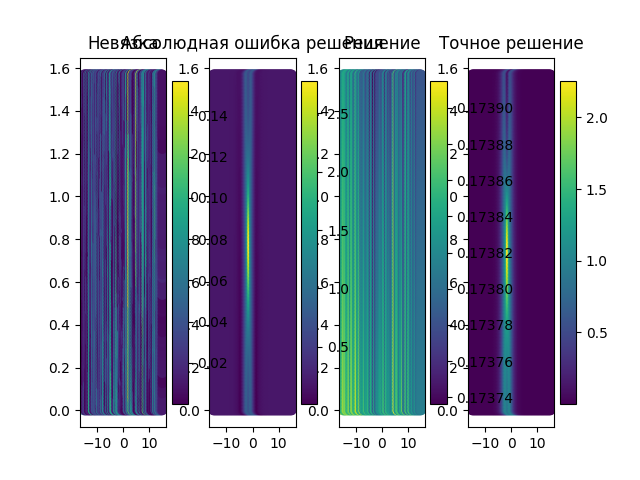

In [25]:
x_coords = torch.linspace(*x_bounds, 100, device=device, dtype=dtype)
y_coords = torch.linspace(*t_bounds, 100, device=device, dtype=dtype)
x_coords.requires_grad = True
y_coords.requires_grad = True
grid_x, grid_y = torch.meshgrid(x_coords, y_coords)
grid_x = grid_x.ravel()
grid_y = grid_y.ravel()
# 2. Evaluate the function at the initial grid points
# The function is expected to handle a batch of points
xy = torch.stack((grid_x, grid_y), dim=1)
guess = model(xy).ravel()
z = residual(guess, grid_x, grid_y)
# z = loss(z, torch.zeros_like(z, device=device, dtype=dtype))
z = z.abs()

# function_values = res_for_generate(grid_x, grid_y)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
sc = ax1.scatter(grid_x.cpu().detach(), grid_y.cpu().detach(), c=z.detach().cpu())
ax1.set_title('Невязка')
sc2 = ax2.scatter(grid_x.cpu().detach(), grid_y.cpu().detach(), c=(guess - exact(grid_x, grid_y)).abs().detach().cpu())
ax2.set_title('Абсолюдная ошибка решения')
sc3 = ax3.scatter(grid_x.cpu().detach(), grid_y.cpu().detach(), c=guess.detach().cpu())
ax3.set_title('Решение')
sc4 = ax4.scatter(grid_x.cpu().detach(), grid_y.cpu().detach(), c=exact(grid_x, grid_y).detach().cpu())
ax4.set_title('Точное решение')
fig.colorbar(sc)
fig.colorbar(sc2)
fig.colorbar(sc3)
fig.colorbar(sc4)

### test for sampling by rad implementation

In [ ]:
x, t = sampler_pde.generate()
x = x.clone()
x.requires_grad = True
t = t.clone()
t.requires_grad = True
# xy = torch.stack((x, t), dim=1)
# z = model(xy).squeeze()
# closs = torch.abs(residual(z, x, z))
# ax.scatter(x.cpu().detach(), t.cpu().detach(), c=closs.cpu().detach(), cmap="rainbow")
ax1.scatter(x.cpu().detach(), t.cpu().detach(), c="red")
x, t = sampler_data.generate()
x = x.clone()
x.requires_grad = True
t = t.clone()
t.requires_grad = True
# xy = torch.stack((x, t), dim=1)
# z = model(xy).squeeze()
# closs = torch.abs(residual(z, x, z))
# ax.scatter(x.cpu().detach(), t.cpu().detach(), c=closs.cpu().detach(), cmap="rainbow")
ax2.scatter(x.cpu().detach(), t.cpu().detach(), c="red")
plt.show(fig)

NameError: name 'ax' is not defined

### Full area points generation with model values

In [26]:
t = torch.linspace(*t_bounds, 100, dtype=dtype, device=device)
t.requires_grad = True
x = torch.linspace(*x_bounds, 100, dtype=dtype, device=device)
x.requires_grad = True
grid_x, grid_t = torch.meshgrid(x, t)
shape = grid_x.shape
X = grid_x.ravel()
T = grid_t.ravel()
XT = torch.stack((X, T), dim=1)
Y = model(XT).ravel()
loss_y = torch.abs(residual(Y, X, T))

x = X.cpu().detach()
t = T.cpu().detach()
y = Y.cpu().detach()
grid_y = y.reshape(shape)
loss_y = loss_y.cpu().detach()
grid_loss_y = loss_y.reshape(shape)
grid_x = grid_x.cpu().detach()
grid_t = grid_t.cpu().detach()

/tmp/ipykernel_57597/64520467.py:12: UserWarning: The following kwargs were not used by contour: 's'
  sc21 = ax21.contourf(grid_x, grid_t, grid_y, s=10)
/tmp/ipykernel_57597/64520467.py:13: UserWarning: The following kwargs were not used by contour: 's'
  sc22 = ax22.contourf(grid_x, grid_t, grid_loss_y, s=10)


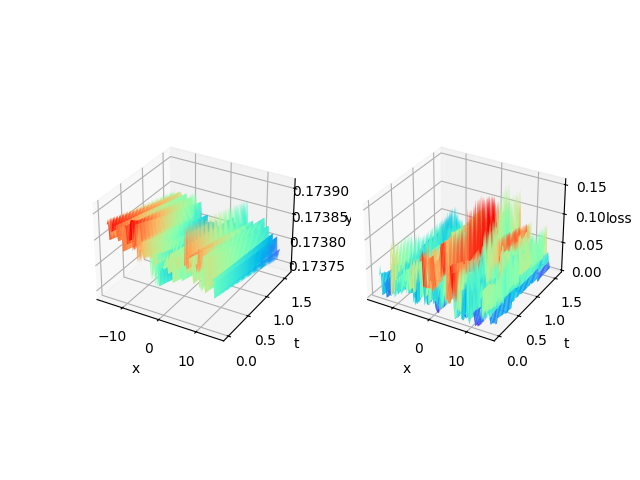

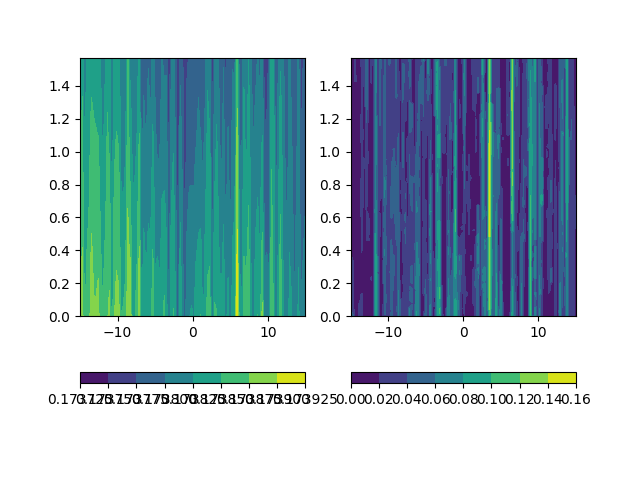

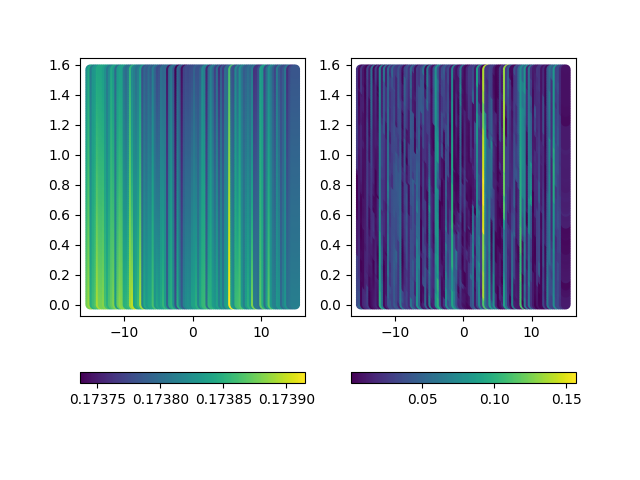

In [27]:
fig1, (ax31, ax32) = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
fig2, (ax21, ax22) = plt.subplots(1, 2)
fig3, (ax11, ax12) = plt.subplots(1, 2)
ax31.set_xlabel('x')
ax31.set_ylabel('t')
ax31.set_zlabel('y')
ax32.set_xlabel('x')
ax32.set_ylabel('t')
ax32.set_zlabel('loss')
ax31.plot_surface(grid_x, grid_t, grid_y, cmap="rainbow")
ax32.plot_surface(grid_x, grid_t, grid_loss_y, cmap="rainbow")
sc21 = ax21.contourf(grid_x, grid_t, grid_y, s=10)
sc22 = ax22.contourf(grid_x, grid_t, grid_loss_y, s=10)
fig2.colorbar(sc21, ax=ax21, orientation="horizontal")
fig2.colorbar(sc22, ax=ax22, orientation="horizontal")
sc11 = ax11.scatter(x, t, c=y)
sc12 = ax12.scatter(x, t, c=loss_y)
fig3.colorbar(sc11, ax=ax11, orientation="horizontal")
fig3.colorbar(sc12, ax=ax12, orientation="horizontal")

In [ ]:
plt.close("all")

In [1]:
from gc import collect

torch.cuda.empty_cache(), collect()

NameError: name 'torch' is not defined

In [78]:
torch.save(model.state_dict(), "model.pt")